<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Real or Fake Jobs

## Contents:
### Part 2 (of 3)
- Problem Statement
- Background
- Data Cleaning
- Data Dictionary
- Exploratory Data Analysis
- [Data Modelling](#Data-Modelling)
    - [Model Fitting & Evaluation](#Model-Fitting-&-Evaluation)
- [Data Modelling with SMOTE](#Data-Modelling-with-SMOTE)
    - [Model Fitting & Evaluation (SMOTE)](#Model-Fitting-&-Evaluation-(SMOTE))
- [Model Selection](#Model-Selection)
- [Misclassified Data](#Misclassified-Data)
- Topic Modelling
- Conclusions
- Recommendations
- References

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import string
import re
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, \
accuracy_score, recall_score, precision_score, plot_roc_curve, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as pipeline

pd.set_option('display.max.columns', None)
pd.set_option('display.max.rows', None)
pd.set_option('display.max.colwidth', 100)

In [2]:
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')

In [3]:
# load the data
df = pd.read_csv('../data/clean_fake_job_postings.csv')

In [4]:
df.head(1)

,has_company_logo,has_questions,required_experience,required_education,industry_grp,text_lemma,word_length,fraudulent
0,1,0,Internship,Bachelor's Degree,Marketing/Advertising,marketing intern food fast growing james beard award winning online food community crowd sourced...,152,0


In [5]:
# dummify categorical variables
categorical_col = [col for col in ['required_experience', 'required_education', 'industry_grp']]
df = pd.get_dummies(df, columns = categorical_col)

In [6]:
df.head(1)

,has_company_logo,has_questions,text_lemma,word_length,fraudulent,required_experience_Associate,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_education_Associate Degree,required_education_Bachelor's Degree,required_education_Certification,required_education_Doctorate,required_education_High School or equivalent,required_education_Master's Degree,required_education_Professional,required_education_Some College Coursework Completed,required_education_Unspecified,required_education_Vocational,industry_grp_Admin/HR,industry_grp_Architecture & Engineering,industry_grp_Arts & Entertainment,industry_grp_Broadcasting/Publishing,industry_grp_Business/Consultancy,industry_grp_Computer Prog,industry_grp_Construction,industry_grp_Education,industry_grp_F&B,industry_grp_Financial Services,industry_grp_Healthcare,industry_grp_ICT,industry_grp_Legal & Accounting,industry_grp_Manufacturing,industry_grp_Marketing/Advertising,industry_grp_Oil & Energy,industry_grp_Others,industry_grp_Public Admin,industry_grp_Real Estate,industry_grp_Scientific R&D,industry_grp_Security and Investigations,industry_grp_Social Services,industry_grp_Telecommunications,industry_grp_Transportation & Storage,industry_grp_Wholesale/Retail
0,1,0,marketing intern food fast growing james beard award winning online food community crowd sourced...,152,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [7]:
# select features
X = df.drop(columns = ['fraudulent'])
y = df['fraudulent']

In [8]:
# train test split of 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y, random_state = 42)

In [9]:
# remove duplicates from text_lemma columns (if any) 
print(f'Shape before removing duplicates: {df.shape}')
df.drop_duplicates(subset = ['text_lemma'], inplace = True)
print(f'Shape after removing duplicates: {df.shape}')

Shape before removing duplicates: (11867, 47)
Shape after removing duplicates: (11867, 47)


### Functions to compute evaluation metrics and best params

In [10]:
# write a function to compute accuracy score for train and test data
def compute_acc_score(model, X_train, X_test, y_train, y_test):
    """
    This function takes in the model, train and test data and returns the accuracy score and 
    the difference between the train and test accuracy scores.
    """
    acc_train = model.score(X_train, y_train)
    acc_test = model.score(X_test, y_test)
    acc_diff = acc_train - acc_test
    
    print(f'The training accuracy score for {(model.__class__.__name__)} is{acc_train: .3f}.')
    print(f'The testing accuracy score for {(model.__class__.__name__)} is{acc_test: .3f}.')
    print(f'The difference in accuracy score for {(model.__class__.__name__)} is{acc_diff: .3f}.')
    print()

In [11]:
# write a function to compute roc auc score
def compute_roc_auc_score(model, X_train, X_test, y_train, y_test):
    """
    This function takes in the model, train and test data and returns the roc auc score
    and the difference between train and test roc auc score.
    """
    roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    roc_auc_diff = roc_auc_train - roc_auc_test
    
    print(f'The training ROC AUC score for {(model.__class__.__name__)} is{roc_auc_train: .3f}.')
    print(f'The testing ROC AUC score for {(model.__class__.__name__)} is{roc_auc_test: .3f}.')
    print(f'The difference in ROC AUC score for {(model.__class__.__name__)} is{roc_auc_diff: .3f}.')
    print()

In [12]:
# write a function to compute recall score
def compute_recall_score(model, X_train, X_test, y_train, y_test):
    """
    This function takes in the model, train and test data and returns the recall score 
    and the difference between train and test recall score.
    """
    rec_train = recall_score(y_true = y_train, y_pred = model.predict(X_train))
    rec_test = recall_score(y_true = y_test, y_pred = model.predict(X_test))
    rec_diff = rec_train - rec_test
    
    print(f'The training recall score for {(model.__class__.__name__)} is{rec_train: .3f}.')
    print(f'The testing recall score for {(model.__class__.__name__)} is{rec_test: .3f}.')
    print(f'The difference in recall score for {(model.__class__.__name__)} is{rec_diff: .3f}.')
    print()

In [13]:
# write a function to print out the accuracy, roc auc and recall score
def eval_metrics(model):
    """
    This function takes in the model and returns the accuracy, ROC AUC and recall scores 
    of both the train and test data.
    """
    compute_acc_score(model, X_train, X_test, y_train, y_test)
    compute_roc_auc_score(model, X_train, X_test, y_train, y_test)
    compute_recall_score(model, X_train, X_test, y_train, y_test)

In [14]:
# write a function to print the best parameters from RandomizedSearchCV
def best_params(name, vectorizer1, model1, vectorizer2, model2):
    """
    This function takes in the model name, vectorizer name, model and returns the best parameters.
    """
    print(f'{name}:')
    print(f'{name} with {vectorizer1} best params: \n {model1.best_params_}')
    print()
    print(f'{name} with {vectorizer2} best params: \n {model2.best_params_}')
    print()

## Data Modelling

### Setting up Transformers

In [15]:
# instantiate vectorizers
cvec = CountVectorizer()
tvec = TfidfVectorizer()

In [16]:
# setting up column transformer for cvec
transformer1 = ColumnTransformer([
    ('cvec', cvec, 'text_lemma'),
    ('ss', StandardScaler(with_mean = False), 
     df[df.columns[~df.columns.isin(['text_lemma', 'fraudulent'])]].columns)],
    remainder = 'passthrough')

In [17]:
# setting up column transformer for tvec
transformer2 = ColumnTransformer(transformers=[
    ('tvec', tvec, 'text_lemma'),
    ('ss', StandardScaler(with_mean = False), 
     df[df.columns[~df.columns.isin(['text_lemma', 'fraudulent'])]].columns)],
    remainder = 'passthrough')

### Setting up Pipelines
We will set up pipelines involving 5 models - (i) Logistic Regression; (ii) Support Vector Classifier; (iii) Multinomial Naive Bayes; (iv) Extreme Gradient Boosting; and (v) K-Nearest Neighbors, and 2 vectorizers - (a) Count Vectorizer; and (b) TFIDF Vectorizer. There will be a total of 10 pipelines.

In [18]:
# create pipeline for logreg cvec
pipe1 = Pipeline([
    ('transformer1', transformer1),
    ('logreg', LogisticRegression(random_state = 42, class_weight = 'balanced', max_iter = 10_000))])

In [19]:
# create pipeline for logreg tvec
pipe2 = Pipeline([
    ('transformer2', transformer2),
    ('logreg', LogisticRegression(random_state = 42, class_weight = 'balanced', max_iter = 10_000))])

In [20]:
# create pipeline for svc cvec
pipe3 = Pipeline([
    ('transformer1', transformer1),
    ('svc', SVC(random_state = 42, class_weight = 'balanced', probability = True, 
                kernel = 'linear', max_iter = 100_000))])

In [21]:
# create pipeline for svc tvec
pipe4 = Pipeline([
    ('transformer2', transformer2),
    ('svc', SVC(random_state = 42, class_weight = 'balanced', probability = True, 
                kernel = 'linear', max_iter = 100_000))])

In [22]:
# create pipeline for xgboost cvec
pipe5 = Pipeline([
    ('transformer1', transformer1),
    ('xgb', XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss', booster = 'gblinear'))])

In [23]:
# create pipeline for xgboost tvec
pipe6 = Pipeline([
    ('transformer2', transformer2),
    ('xgb', XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss', booster = 'gblinear'))])

In [24]:
# create pipeline for mnb cvec
pipe7 = Pipeline([
    ('transformer1', transformer1),
    ('mnb', MultinomialNB())])

In [25]:
# create pipeline for mnb tvec
pipe8 = Pipeline([
    ('transformer2', transformer2),
    ('mnb', MultinomialNB())])

In [26]:
# create pipeline for knn cvec
pipe9 = Pipeline([
    ('transformer1', transformer1),
    ('knn', KNeighborsClassifier())])

In [27]:
# create pipeline for knn tvec
pipe10 = Pipeline([
    ('transformer2', transformer2),
    ('knn', KNeighborsClassifier())])

### Baseline Model 
We set a logistic regression model with cvec and default parameters (i.e. C = 1, penalty = l2, solver = 'lbfgs') as the baseline model, as it is easy to understand and interpret. As this is an imbalanced classification problem, we should not be using accuracy score as the evaluation metric. Instead, we will compare the ROC AUC score of the baseline model against the other 9 models. The final model that we select will have to outperform the baseline model's ROC AUC score.

In [28]:
# fit baseline pipe and print the scores
baseline_model = pipe1.fit(X_train, y_train)
eval_metrics(baseline_model)

The training accuracy score for Pipeline is 1.000.
The testing accuracy score for Pipeline is 0.971.
The difference in accuracy score for Pipeline is 0.029.

The training ROC AUC score for Pipeline is 1.000.
The testing ROC AUC score for Pipeline is 0.933.
The difference in ROC AUC score for Pipeline is 0.067.

The training recall score for Pipeline is 1.000.
The testing recall score for Pipeline is 0.692.
The difference in recall score for Pipeline is 0.308.



**Observation**: The ROC AUC score tells how much the model is capable at distinguishing between the two classes. The closer the score is to 1, the better the model is at distinguishing between fraudulent (positives) and non-fraudulent job ads. Our **baseline ROC AUC score is 0.933**, which is quite good.

### Model Fitting & Evaluation
#### Logistic Regression

In [29]:
# instantiate and fit logreg models
tvec_logreg = pipe2.fit(X_train, y_train);

In [30]:
# eval logreg tvec
eval_metrics(tvec_logreg)

The training accuracy score for Pipeline is 0.960.
The testing accuracy score for Pipeline is 0.942.
The difference in accuracy score for Pipeline is 0.018.

The training ROC AUC score for Pipeline is 0.997.
The testing ROC AUC score for Pipeline is 0.950.
The difference in ROC AUC score for Pipeline is 0.047.

The training recall score for Pipeline is 1.000.
The testing recall score for Pipeline is 0.795.
The difference in recall score for Pipeline is 0.205.



**Observation**: The ROC AUC score for Logistic Regression with tvec is 0.950, which is higher than the score of the baseline model. This indicates that `LogReg with tvec` is probably a good model at classifying between real and fake job ads.

#### Support Vector Classifier

In [31]:
# instantiate and fit SVC models
cvec_svc = pipe3.fit(X_train, y_train);
tvec_svc = pipe4.fit(X_train, y_train);

In [32]:
# eval svc cvec
eval_metrics(cvec_svc)

The training accuracy score for Pipeline is 1.000.
The testing accuracy score for Pipeline is 0.971.
The difference in accuracy score for Pipeline is 0.029.

The training ROC AUC score for Pipeline is 1.000.
The testing ROC AUC score for Pipeline is 0.925.
The difference in ROC AUC score for Pipeline is 0.075.

The training recall score for Pipeline is 1.000.
The testing recall score for Pipeline is 0.637.
The difference in recall score for Pipeline is 0.363.



In [33]:
# eval svc tvec
eval_metrics(tvec_svc)

The training accuracy score for Pipeline is 0.997.
The testing accuracy score for Pipeline is 0.978.
The difference in accuracy score for Pipeline is 0.020.

The training ROC AUC score for Pipeline is 1.000.
The testing ROC AUC score for Pipeline is 0.950.
The difference in ROC AUC score for Pipeline is 0.050.

The training recall score for Pipeline is 1.000.
The testing recall score for Pipeline is 0.644.
The difference in recall score for Pipeline is 0.356.



**Observation**: The ROC AUC score for SVC with cvec is 0.925, lower than the baseline. The ROC AUC score for SVC with tvec is 0.950, higher than the baseline score. This indicates that the `SVC with tvec` is probably a good model at classifying between real and fake job ads.

#### Extreme Gradient Boosting

In [34]:
# instantiate and fit XGB models
cvec_xgb = pipe5.fit(X_train, y_train);
tvec_xgb = pipe6.fit(X_train, y_train);

In [35]:
# eval xgb cvec
eval_metrics(cvec_xgb)

The training accuracy score for Pipeline is 1.000.
The testing accuracy score for Pipeline is 0.977.
The difference in accuracy score for Pipeline is 0.023.

The training ROC AUC score for Pipeline is 1.000.
The testing ROC AUC score for Pipeline is 0.919.
The difference in ROC AUC score for Pipeline is 0.081.

The training recall score for Pipeline is 1.000.
The testing recall score for Pipeline is 0.548.
The difference in recall score for Pipeline is 0.452.



In [36]:
# eval xgb tvec
eval_metrics(tvec_xgb)

The training accuracy score for Pipeline is 1.000.
The testing accuracy score for Pipeline is 0.979.
The difference in accuracy score for Pipeline is 0.021.

The training ROC AUC score for Pipeline is 1.000.
The testing ROC AUC score for Pipeline is 0.938.
The difference in ROC AUC score for Pipeline is 0.062.

The training recall score for Pipeline is 1.000.
The testing recall score for Pipeline is 0.541.
The difference in recall score for Pipeline is 0.459.



**Observation**: The ROC AUC score for XGB with cvec is 0.919, lower than the baseline. The ROC AUC score for XGB with tvec is 0.938, higher than the baseline score. This indicates that the `XGB with tvec` is probably a good model at classifying between real and fake job ads.

#### Multinomial Naive Bayes

In [37]:
# instantiate and fit MNB models
cvec_mnb = pipe7.fit(X_train, y_train);
tvec_mnb = pipe8.fit(X_train, y_train);

In [38]:
# eval mnb cvec
eval_metrics(cvec_mnb)

The training accuracy score for Pipeline is 0.974.
The testing accuracy score for Pipeline is 0.969.
The difference in accuracy score for Pipeline is 0.004.

The training ROC AUC score for Pipeline is 0.925.
The testing ROC AUC score for Pipeline is 0.875.
The difference in ROC AUC score for Pipeline is 0.051.

The training recall score for Pipeline is 0.400.
The testing recall score for Pipeline is 0.274.
The difference in recall score for Pipeline is 0.126.



In [39]:
# eval mnb tvec
eval_metrics(tvec_mnb)

The training accuracy score for Pipeline is 0.959.
The testing accuracy score for Pipeline is 0.959.
The difference in accuracy score for Pipeline is 0.000.

The training ROC AUC score for Pipeline is 0.828.
The testing ROC AUC score for Pipeline is 0.843.
The difference in ROC AUC score for Pipeline is-0.014.

The training recall score for Pipeline is 0.000.
The testing recall score for Pipeline is 0.000.
The difference in recall score for Pipeline is 0.000.



**Observation**: The ROC AUC score for both MNB with cvec and MNB with tvec is lower than the baseline model. This suggests that the MNB is not a good model for classifying between real and fake job ads, likely because of the imbalanced class.

#### K-Nearest Neighbors

In [40]:
# instantiate and fit KNN models
cvec_knn = pipe9.fit(X_train, y_train);
tvec_knn = pipe10.fit(X_train, y_train);

In [41]:
# eval knn cvec
eval_metrics(cvec_knn)

The training accuracy score for Pipeline is 0.975.
The testing accuracy score for Pipeline is 0.967.
The difference in accuracy score for Pipeline is 0.008.

The training ROC AUC score for Pipeline is 0.974.
The testing ROC AUC score for Pipeline is 0.869.
The difference in ROC AUC score for Pipeline is 0.105.

The training recall score for Pipeline is 0.482.
The testing recall score for Pipeline is 0.349.
The difference in recall score for Pipeline is 0.133.



In [42]:
# eval knn tvec
eval_metrics(tvec_knn)

The training accuracy score for Pipeline is 0.971.
The testing accuracy score for Pipeline is 0.964.
The difference in accuracy score for Pipeline is 0.007.

The training ROC AUC score for Pipeline is 0.981.
The testing ROC AUC score for Pipeline is 0.844.
The difference in ROC AUC score for Pipeline is 0.137.

The training recall score for Pipeline is 0.453.
The testing recall score for Pipeline is 0.349.
The difference in recall score for Pipeline is 0.104.



**Observation**: The ROC AUC score for both KNN with cvec and KNN with tvec is lower than the baseline model. This suggests that the KNN is not a good model for classifying between real and fake job ads, likely because of the imbalanced class.

### Summary of Model Results
A summary of the models' scores is appended in the table below. 

Generally, there seem to be overfitting across all models except for the Multinomial Naive Bayes with tvec, as it has higher test score than train score indicating that it can generalize well to unseen data. However, the ROC AUC score for MNB with tvec is lower than that of the baseline model. Also, the recall score of MNB with tvec is 0. This is likely because of the imbalanced class, where the positives (fraudulent) are the minority class with only 4% data. This means that the MNB with tvec is not good at classifying positives.

The top 2 models with the highest test ROC AUC score of 0.950 is the Logistic Regression with tvec and the Support Vector Classifier with tvec. Both models performed better than the baseline model (logreg with cvec). Comparing the recall scores, **Logistic Regression with tvec** has a higher recall score of 0.795. 

As this is an imbalanced class, we will try to perform Synthetic Minority Oversampling Technique (SMOTE) to fix the issue of imbalanced class and test against more models to see if we can obtain better results.

| S/N | Model | Train Accuracy | Test Accuracy | Train ROC AUC | Test ROC AUC | Train Recall | Test Recall | 
|:---:|:---|:---|:---|:---|:---|:---|:---|
| 1 | Logistic Regression with cvec       | 1.000 | 0.971 | 1.000 | 0.933 | 1.000 | 0.692 |
| 2 | **Logistic Regression with tvec**   | 0.960 | 0.942 | 0.997 |**0.950**| 1.000 | 0.795 |
| 3 | Support Vector Classifier with cvec | 1.000 | 0.971 | 1.000 | 0.925 | 1.000 | 0.637 |
| 4 |**Support Vector Classifier with tvec**| 0.997 | 0.978 | 1.000 |**0.950**| 1.000 | 0.644 |
| 5 | Extreme Gradient Boost with cvec    | 1.000 | 0.977 | 1.000 | 0.919 | 1.000 | 0.548 |
| 6 | Extreme Gradient Boost with tvec    | 1.000 | 0.979 | 1.000 | 0.938 | 1.000 | 0.541 |
| 7 | Multinomial Naive Bayes with cvec   | 0.974 | 0.969 | 0.925 | 0.875 | 0.400 | 0.274 |
| 8 | Multinomial Naive Bayes with tvec   | 0.959 | 0.959 | 0.828 | 0.843 | 0.000 | 0.000 |
| 9 | K Nearest Neighbors with cvec       | 0.975 | 0.967 | 0.974 | 0.869 | 0.482 | 0.349 |
|10 | K Nearest Neighbors with tvec       | 0.971 | 0.964 | 0.981 | 0.844 | 0.453 | 0.349 |

## Data Modelling with SMOTE
The Synthetic Minority Oversampling Technique (SMOTE) technique generates synthetic data for the minority class. SMOTE works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors [(source)](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/).

SMOTE algorithm works in 4 simple steps:
1. Choose a minority class as the input vector
2. Find its k nearest neighbors (k_neighbors is specified as an argument in the `SMOTE()` function)
3. Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
4. Repeat the steps until data is balanced

### Setting up SMOTE Pipelines

In [43]:
# create pipeline for logreg cvec with SMOTE
pipe1_smote = pipeline([
    ('transformer1', transformer1),
    ('smote', SMOTE(random_state = 42)),
    ('logreg', LogisticRegression(random_state = 42, class_weight = 'balanced', max_iter = 100_000))])

In [44]:
# create pipeline for logreg tvec with SMOTE
pipe2_smote = pipeline([
    ('transformer2', transformer2),
    ('smote', SMOTE(random_state = 42)),
    ('logreg', LogisticRegression(random_state = 42, class_weight = 'balanced', max_iter = 100_000))])

In [45]:
# create pipeline for svc cvec with SMOTE
pipe3_smote = pipeline([
    ('transformer1', transformer1),
    ('smote', SMOTE(random_state = 42)),
    ('svc', SVC(random_state = 42, class_weight = 'balanced', probability = True, 
                kernel = 'linear', max_iter = 100_000))])

In [46]:
# create pipeline for svc tvec with SMOTE
pipe4_smote = pipeline([
    ('transformer2', transformer2),
    ('smote', SMOTE(random_state = 42)),
    ('svc', SVC(random_state = 42, class_weight = 'balanced', probability = True, 
                kernel = 'linear', max_iter = 100_000))])

In [47]:
# create pipeline for xgb cvec with SMOTE
pipe5_smote = pipeline([
    ('transformer1', transformer1),
    ('smote', SMOTE(random_state = 42)),
    ('xgb', XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss', booster = 'gblinear'))])

In [48]:
# create pipeline for xgb tvec with SMOTE
pipe6_smote = pipeline([
    ('transformer2', transformer2),
    ('smote', SMOTE(random_state = 42)),
    ('xgb', XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss', booster = 'gblinear'))])

In [49]:
# create pipeline for mnb cvec with SMOTE
pipe7_smote = pipeline([
    ('transformer1', transformer1),
    ('smote', SMOTE(random_state = 42)),
    ('mnb', MultinomialNB())])

In [50]:
# create pipeline for mnb tvec with SMOTE
pipe8_smote = pipeline([
    ('transformer2', transformer2),
    ('smote', SMOTE(random_state = 42)),
    ('mnb', MultinomialNB())])

In [51]:
# create pipeline for knn cvec with SMOTE
pipe9_smote = pipeline([
    ('transformer1', transformer1),
    ('smote', SMOTE(random_state = 42)),
    ('knn', KNeighborsClassifier())])

In [52]:
# create pipeline for knn tvec with SMOTE
pipe10_smote = pipeline([
    ('transformer2', transformer2),
    ('smote', SMOTE(random_state = 42)),
    ('knn', KNeighborsClassifier())])

In [53]:
# create pipeline for rf cvec with SMOTE
pipe11_smote = pipeline([
    ('transformer1', transformer1),
    ('smote', SMOTE(random_state = 42)),
    ('rf', RandomForestClassifier(random_state = 42))])

In [54]:
# create pipeline for rf tvec with SMOTE
pipe12_smote = pipeline([
    ('transformer2', transformer2),
    ('smote', SMOTE(random_state = 42)),
    ('rf', RandomForestClassifier(random_state = 42))])

In [55]:
# create pipeline for adaboost cvec with SMOTE
pipe13_smote = pipeline([
    ('transformer1', transformer1),
    ('smote', SMOTE(random_state = 42)),
    ('adab', AdaBoostClassifier(random_state = 42))])

In [56]:
# create pipeline for adaboost tvec with SMOTE
pipe14_smote = pipeline([
    ('transformer2', transformer2),
    ('smote', SMOTE(random_state = 42)),
    ('adab', AdaBoostClassifier(random_state = 42))])

### Setting Parameter Grids
We then set the parameters for the pipelines so that we can tune the hyperparameters and try to improve the model performance. 

In [57]:
# for logreg cvec
param_grid1 = {
    'transformer1__cvec__min_df': [0.005, 0.01, 0.015], 
    'transformer1__cvec__max_df': [0.5, 0.6, 0.7, 0.8],
    'transformer1__cvec__ngram_range': [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)], 
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [58]:
# for logreg tvec
param_grid2 = {
    'transformer2__tvec__min_df': [0.005, 0.01, 0.015], 
    'transformer2__tvec__max_df': [0.5, 0.6, 0.7, 0.8],
    'transformer2__tvec__ngram_range': [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],
    'transformer2__tvec__max_features': [500, 1000, 1500, 2000, 2500, 3000],
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [59]:
# for xgb cvec
param_grid5 = {
    'transformer1__cvec__min_df': [0.003, 0.005, 0.01], 
    'transformer1__cvec__max_df': [0.5, 0.6, 0.7, 0.8],
    'transformer1__cvec__ngram_range': [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],
    'xgb__n_estimators': [50, 100, 150, 200, 250, 300],
    'xgb__learning_rate': [0.1, 0.2, 0.3, 0.5]}

In [60]:
# for xgb tvec
param_grid6 = {
    'transformer2__tvec__min_df': [0.005, 0.01, 0.015], 
    'transformer2__tvec__max_df': [0.6, 0.7, 0.8],
    'transformer2__tvec__ngram_range': [(1,2), (1,3), (2,2), (2,3), (3,3)],
    'xgb__n_estimators': [50, 100, 150, 200, 250, 300],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]}

In [61]:
# for mnb cvec
param_grid7 = {
    'transformer1__cvec__min_df': [0.003, 0.005, 0.01], 
    'transformer1__cvec__max_df': [0.5, 0.6, 0.7, 0.8],
    'transformer1__cvec__ngram_range': [(1, 1), (2, 2), (1, 2), (2, 3)],
    'mnb__alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10]}

In [62]:
# for mnb tvec
param_grid8 = {
    'transformer2__tvec__min_df': [0.003, 0.005, 0.01], 
    'transformer2__tvec__max_df': [0.5, 0.6, 0.7, 0.8],
    'transformer2__tvec__ngram_range': [(1, 1), (2, 2), (1, 2), (2, 3)],
    'mnb__alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10]}

In [63]:
# for knn cvec
param_grid9 = {
    'transformer1__cvec__min_df': [0.003, 0.005, 0.01], 
    'transformer1__cvec__max_df': [0.5, 0.6, 0.7, 0.8],
    'transformer1__cvec__ngram_range': [(1, 1), (2, 2), (1, 2), (2, 3)],
    'knn__n_neighbors': [5, 10, 15, 20, 25]}

In [64]:
# for knn tvec
param_grid10 = {
    'transformer2__tvec__min_df': [0.003, 0.005, 0.01], 
    'transformer2__tvec__max_df': [0.5, 0.6, 0.7, 0.8],
    'transformer2__tvec__ngram_range': [(1, 1), (2, 2), (1, 2), (2, 3)],
    'knn__n_neighbors': [5, 10, 15, 20, 25]}

In [65]:
# for rf cvec
param_grid11 = {
    'transformer1__cvec__min_df': [0.005, 0.01, 0.015], 
    'transformer1__cvec__max_df': [0.6, 0.7],
    'transformer1__cvec__ngram_range': [(1,2), (1,3), (2,2), (2,3)],
    'rf__n_estimators': [150, 200, 250, 300]}

In [66]:
# for rf tvec
param_grid12 = {
    'transformer2__tvec__min_df': [0.005, 0.01, 0.015], 
    'transformer2__tvec__max_df': [0.6, 0.7],
    'transformer2__tvec__ngram_range': [(1,2), (1,3), (2,2), (2,3)],
    'rf__n_estimators': [150, 200, 250, 300]}

In [67]:
# for adaboost cvec
param_grid13 = {
    'transformer1__cvec__min_df': [0.005, 0.01], 
    'transformer1__cvec__max_df': [0.6, 0.7],
    'transformer1__cvec__ngram_range': [(1,2), (1,3), (2,3)],
    'adab__n_estimators': [200, 250, 300]}

In [68]:
# for adaboost tvec
param_grid14 = {
    'transformer2__tvec__min_df': [0.005, 0.01], 
    'transformer2__tvec__max_df': [0.6, 0.7],
    'transformer2__tvec__ngram_range': [(1,2), (1,3), (2,3)],
    'adab__n_estimators': [200, 250, 300]}

### Baseline SMOTE Model 
We set the baseline SMOTE model to be a logistic regression model with cvec, and find the baseline ROC AUC score. The subsequent models that we select will have to outperform the baseline ROC AUC score.

In [69]:
# compute duration required to fit the model
start = time()

# instantiate and fit LogReg cvec SMOTE
sm_cvec_logreg = RandomizedSearchCV(pipe1_smote, param_grid1, cv = 5, random_state = 42)
sm_cvec_logreg.fit(X_train, y_train);

end = time()
print(f'Time taken for LogReg cvec:{end - start: .2f}s')

Time taken for LogReg cvec: 82.86s


In [70]:
# eval logreg cvec with SMOTE
eval_metrics(sm_cvec_logreg)

The training accuracy score for RandomizedSearchCV is 1.000.
The testing accuracy score for RandomizedSearchCV is 0.966.
The difference in accuracy score for RandomizedSearchCV is 0.034.

The training ROC AUC score for RandomizedSearchCV is 1.000.
The testing ROC AUC score for RandomizedSearchCV is 0.925.
The difference in ROC AUC score for RandomizedSearchCV is 0.075.

The training recall score for RandomizedSearchCV is 1.000.
The testing recall score for RandomizedSearchCV is 0.664.
The difference in recall score for RandomizedSearchCV is 0.336.



**Observation**: The closer the ROC AUC score is to 1, the better the model. Our **baseline SMOTE model has a ROC AUC score is 0.925**, which is quite good. 

### Model Fitting & Evaluation (SMOTE)

#### Logistic Regression

In [71]:
# compute duration required to fit the model
start = time()

# instantiate and fit LogReg tvec SMOTE
sm_tvec_logreg_best = RandomizedSearchCV(pipe2_smote, param_grid2, cv = 5, random_state = 42)
sm_tvec_logreg_best.fit(X_train, y_train);

end = time()
print(f'Time taken for LogReg tvec:{end - start: .2f}s')

Time taken for LogReg tvec: 138.45s


In [72]:
# get best parameters for LogReg SMOTE
best_params('Logistic Regression', 'cvec', sm_cvec_logreg, 'tvec', sm_tvec_logreg_best)

Logistic Regression:
Logistic Regression with cvec best params: 
 {'transformer1__cvec__ngram_range': (1, 1), 'transformer1__cvec__min_df': 0.005, 'transformer1__cvec__max_df': 0.8, 'logreg__C': 100}

Logistic Regression with tvec best params: 
 {'transformer2__tvec__ngram_range': (1, 1), 'transformer2__tvec__min_df': 0.01, 'transformer2__tvec__max_features': 2500, 'transformer2__tvec__max_df': 0.6, 'logreg__C': 1}



In [73]:
# eval logreg tvec with SMOTE
eval_metrics(sm_tvec_logreg_best)

The training accuracy score for RandomizedSearchCV is 0.961.
The testing accuracy score for RandomizedSearchCV is 0.948.
The difference in accuracy score for RandomizedSearchCV is 0.013.

The training ROC AUC score for RandomizedSearchCV is 0.995.
The testing ROC AUC score for RandomizedSearchCV is 0.946.
The difference in ROC AUC score for RandomizedSearchCV is 0.050.

The training recall score for RandomizedSearchCV is 0.991.
The testing recall score for RandomizedSearchCV is 0.801.
The difference in recall score for RandomizedSearchCV is 0.190.



**Observation**: The ROC AUC score for Logistic Regression with tvec (SMOTE) is 0.946, which is higher than the score of the baseline model. This indicates that `LogReg with tvec (SMOTE)` is probably a good model at classifying between real and fake job ads.

#### Support Vector Classifier

In [74]:
# instantiate and fit svc smote models
sm_cvec_svc = pipe3_smote.fit(X_train, y_train);
sm_tvec_svc = pipe4_smote.fit(X_train, y_train);

In [75]:
# eval svc cvec with SMOTE
eval_metrics(sm_cvec_svc)

The training accuracy score for Pipeline is 1.000.
The testing accuracy score for Pipeline is 0.971.
The difference in accuracy score for Pipeline is 0.029.

The training ROC AUC score for Pipeline is 1.000.
The testing ROC AUC score for Pipeline is 0.890.
The difference in ROC AUC score for Pipeline is 0.110.

The training recall score for Pipeline is 1.000.
The testing recall score for Pipeline is 0.637.
The difference in recall score for Pipeline is 0.363.



In [76]:
# eval svc tvec with SMOTE
eval_metrics(sm_tvec_svc)

The training accuracy score for Pipeline is 0.999.
The testing accuracy score for Pipeline is 0.978.
The difference in accuracy score for Pipeline is 0.021.

The training ROC AUC score for Pipeline is 1.000.
The testing ROC AUC score for Pipeline is 0.897.
The difference in ROC AUC score for Pipeline is 0.103.

The training recall score for Pipeline is 1.000.
The testing recall score for Pipeline is 0.630.
The difference in recall score for Pipeline is 0.370.



**Observation**: The ROC AUC score for both SVC with cvec (SMOTE) and SVC with tvec (SMOTE) is lower than the baseline model. It seems like SVC model performed better at classifying between real and fake job ads when SMOTE was not performed to the dataset.

#### Extreme Gradient Boost

In [77]:
# compute duration required to fit the model
start = time()

# instantiate and fit XGB cvec SMOTE
sm_cvec_xgb_best = RandomizedSearchCV(pipe5_smote, param_grid5, cv = 5, random_state = 42)
sm_cvec_xgb_best.fit(X_train, y_train);

end = time()
print(f'Time taken for XGB cvec:{end - start: .2f}s')

Time taken for XGB cvec: 81.41s


In [78]:
# compute duration required to fit the model
start = time()

# instantiate and fit XGB tvec SMOTE
sm_tvec_xgb_best = RandomizedSearchCV(pipe6_smote, param_grid6, cv = 5, random_state = 42)
sm_tvec_xgb_best.fit(X_train, y_train);

end = time()
print(f'Time taken for XGB tvec:{end - start: .2f}s')

Time taken for XGB tvec: 111.08s


In [79]:
# get best parameters for XGB SMOTE
best_params('Extreme Gradient Boost', 'cvec', sm_cvec_xgb_best, 'tvec', sm_tvec_xgb_best)

Extreme Gradient Boost:
Extreme Gradient Boost with cvec best params: 
 {'xgb__n_estimators': 50, 'xgb__learning_rate': 0.3, 'transformer1__cvec__ngram_range': (1, 2), 'transformer1__cvec__min_df': 0.005, 'transformer1__cvec__max_df': 0.7}

Extreme Gradient Boost with tvec best params: 
 {'xgb__n_estimators': 250, 'xgb__learning_rate': 0.1, 'transformer2__tvec__ngram_range': (1, 2), 'transformer2__tvec__min_df': 0.005, 'transformer2__tvec__max_df': 0.7}



In [80]:
# eval xgb cvec with SMOTE
eval_metrics(sm_cvec_xgb_best)

The training accuracy score for RandomizedSearchCV is 1.000.
The testing accuracy score for RandomizedSearchCV is 0.974.
The difference in accuracy score for RandomizedSearchCV is 0.026.

The training ROC AUC score for RandomizedSearchCV is 1.000.
The testing ROC AUC score for RandomizedSearchCV is 0.917.
The difference in ROC AUC score for RandomizedSearchCV is 0.083.

The training recall score for RandomizedSearchCV is 1.000.
The testing recall score for RandomizedSearchCV is 0.582.
The difference in recall score for RandomizedSearchCV is 0.418.



In [81]:
# eval xgb tvec with SMOTE
eval_metrics(sm_tvec_xgb_best)

The training accuracy score for RandomizedSearchCV is 1.000.
The testing accuracy score for RandomizedSearchCV is 0.978.
The difference in accuracy score for RandomizedSearchCV is 0.022.

The training ROC AUC score for RandomizedSearchCV is 1.000.
The testing ROC AUC score for RandomizedSearchCV is 0.945.
The difference in ROC AUC score for RandomizedSearchCV is 0.055.

The training recall score for RandomizedSearchCV is 1.000.
The testing recall score for RandomizedSearchCV is 0.610.
The difference in recall score for RandomizedSearchCV is 0.390.



**Observation**: The ROC AUC score for XGB with cvec (SMOTE) is 0.917, lower than the baseline. The ROC AUC score for XGB with tvec (SMOTE) is 0.945, higher than the baseline score. This indicates that the `XGB with tvec (SMOTE)` is probably a good model at classifying between real and fake job ads.

#### Multinomial Naive Bayes

In [82]:
# compute duration required to fit the model
start = time()

# instantiate and fit MNB cvec SMOTE
sm_cvec_mnb_best = RandomizedSearchCV(pipe7_smote, param_grid7, cv = 5, random_state = 42)
sm_cvec_mnb_best.fit(X_train, y_train);

end = time()
print(f'Time taken for MNB cvec:{end - start: .2f}s')

Time taken for MNB cvec: 58.81s


In [83]:
# compute duration required to fit the model
start = time()

# instantiate and fit MNB tvec SMOTE
sm_tvec_mnb_best = RandomizedSearchCV(pipe8_smote, param_grid8, cv = 5, random_state = 42)
sm_tvec_mnb_best.fit(X_train, y_train);

end = time()
print(f'Time taken for MNB tvec:{end - start: .2f}s')

Time taken for MNB tvec: 59.70s


In [84]:
# get best parameters for MNB SMOTE
best_params('Multinomial Naive Bayes', 'cvec', sm_cvec_mnb_best, 'tvec', sm_tvec_mnb_best)

Multinomial Naive Bayes:
Multinomial Naive Bayes with cvec best params: 
 {'transformer1__cvec__ngram_range': (1, 2), 'transformer1__cvec__min_df': 0.003, 'transformer1__cvec__max_df': 0.6, 'mnb__alpha': 0.1}

Multinomial Naive Bayes with tvec best params: 
 {'transformer2__tvec__ngram_range': (1, 2), 'transformer2__tvec__min_df': 0.005, 'transformer2__tvec__max_df': 0.8, 'mnb__alpha': 0.001}



In [85]:
# eval mnb cvec with SMOTE
eval_metrics(sm_cvec_mnb_best)

The training accuracy score for RandomizedSearchCV is 0.962.
The testing accuracy score for RandomizedSearchCV is 0.953.
The difference in accuracy score for RandomizedSearchCV is 0.009.

The training ROC AUC score for RandomizedSearchCV is 0.979.
The testing ROC AUC score for RandomizedSearchCV is 0.923.
The difference in ROC AUC score for RandomizedSearchCV is 0.056.

The training recall score for RandomizedSearchCV is 0.876.
The testing recall score for RandomizedSearchCV is 0.664.
The difference in recall score for RandomizedSearchCV is 0.212.



In [86]:
# eval mnb tvec with SMOTE
eval_metrics(sm_tvec_mnb_best)

The training accuracy score for RandomizedSearchCV is 0.922.
The testing accuracy score for RandomizedSearchCV is 0.922.
The difference in accuracy score for RandomizedSearchCV is-0.000.

The training ROC AUC score for RandomizedSearchCV is 0.946.
The testing ROC AUC score for RandomizedSearchCV is 0.919.
The difference in ROC AUC score for RandomizedSearchCV is 0.027.

The training recall score for RandomizedSearchCV is 0.776.
The testing recall score for RandomizedSearchCV is 0.712.
The difference in recall score for RandomizedSearchCV is 0.064.



**Observation**: The ROC AUC score for both MNB with cvec (SMOTE) and MNB with tvec (SMOTE) is lower than the baseline model. However, the scores have improved quite significantly after SMOTE was performed, indicating that MNB is able to quite accurately classify between real and fake job ads if the data was not imbalanced.

#### K-Nearest Neighbors

In [87]:
# compute duration required to fit the model
start = time()

# instantiate and fit KNN cvec SMOTE
sm_cvec_knn_best = RandomizedSearchCV(pipe9_smote, param_grid9, cv = 5, random_state = 42)
sm_cvec_knn_best.fit(X_train, y_train);

end = time()
print(f'Time taken for KNN cvec:{end - start: .2f}s')

Time taken for KNN cvec: 95.82s


In [88]:
# compute duration required to fit the model
start = time()

# instantiate and fit KNN tvec SMOTE
sm_tvec_knn_best = RandomizedSearchCV(pipe10_smote, param_grid10, cv = 5, random_state = 42)
sm_tvec_knn_best.fit(X_train, y_train);

end = time()
print(f'Time taken for KNN tvec:{end - start: .2f}s')

Time taken for KNN tvec: 97.21s


In [89]:
# get best parameters for KNN SMOTE
best_params('K-Nearest Neighbors', 'cvec', sm_cvec_knn_best, 'tvec', sm_tvec_knn_best)

K-Nearest Neighbors:
K-Nearest Neighbors with cvec best params: 
 {'transformer1__cvec__ngram_range': (2, 2), 'transformer1__cvec__min_df': 0.01, 'transformer1__cvec__max_df': 0.5, 'knn__n_neighbors': 5}

K-Nearest Neighbors with tvec best params: 
 {'transformer2__tvec__ngram_range': (2, 2), 'transformer2__tvec__min_df': 0.01, 'transformer2__tvec__max_df': 0.5, 'knn__n_neighbors': 5}



In [90]:
# eval knn cvec with SMOTE
eval_metrics(sm_cvec_knn_best)

The training accuracy score for RandomizedSearchCV is 0.927.
The testing accuracy score for RandomizedSearchCV is 0.892.
The difference in accuracy score for RandomizedSearchCV is 0.035.

The training ROC AUC score for RandomizedSearchCV is 1.000.
The testing ROC AUC score for RandomizedSearchCV is 0.877.
The difference in ROC AUC score for RandomizedSearchCV is 0.123.

The training recall score for RandomizedSearchCV is 1.000.
The testing recall score for RandomizedSearchCV is 0.760.
The difference in recall score for RandomizedSearchCV is 0.240.



In [91]:
# eval knn tvec with SMOTE
eval_metrics(sm_tvec_knn_best)

The training accuracy score for RandomizedSearchCV is 0.928.
The testing accuracy score for RandomizedSearchCV is 0.896.
The difference in accuracy score for RandomizedSearchCV is 0.032.

The training ROC AUC score for RandomizedSearchCV is 1.000.
The testing ROC AUC score for RandomizedSearchCV is 0.862.
The difference in ROC AUC score for RandomizedSearchCV is 0.137.

The training recall score for RandomizedSearchCV is 1.000.
The testing recall score for RandomizedSearchCV is 0.760.
The difference in recall score for RandomizedSearchCV is 0.240.



**Observation**: The ROC AUC score for both KNN with cvec (SMOTE) and KNN with tvec (SMOTE) is lower than the baseline model. However, the scores have improved after SMOTE was performed, indicating that KNN is able to quite accurately classify between real and fake job ads if the data was not imbalanced. 

#### Random Forest

In [92]:
# compute duration required to fit the model
start = time()

# instantiate and fit RF cvec SMOTE
sm_cvec_rf_best = RandomizedSearchCV(pipe11_smote, param_grid11, cv = 5, random_state = 42)
sm_cvec_rf_best.fit(X_train, y_train);

end = time()
print(f'Time taken for RF cvec:{end - start: .2f}s')

Time taken for RF cvec: 349.86s


In [93]:
# compute duration required to fit the model
start = time()

# instantiate and fit RF tvec SMOTE
sm_tvec_rf_best = RandomizedSearchCV(pipe12_smote, param_grid12, cv = 5, random_state = 42)
sm_tvec_rf_best.fit(X_train, y_train);

end = time()
print(f'Time taken for RF tvec:{end - start: .2f}s')

Time taken for RF tvec: 422.91s


In [94]:
# get best parameters for RF SMOTE
best_params('Random Forest', 'cvec', sm_cvec_rf_best, 'tvec', sm_tvec_rf_best)

Random Forest:
Random Forest with cvec best params: 
 {'transformer1__cvec__ngram_range': (2, 2), 'transformer1__cvec__min_df': 0.01, 'transformer1__cvec__max_df': 0.7, 'rf__n_estimators': 200}

Random Forest with tvec best params: 
 {'transformer2__tvec__ngram_range': (1, 2), 'transformer2__tvec__min_df': 0.005, 'transformer2__tvec__max_df': 0.6, 'rf__n_estimators': 150}



In [95]:
# eval rf cvec with SMOTE
eval_metrics(sm_cvec_rf_best)

The training accuracy score for RandomizedSearchCV is 1.000.
The testing accuracy score for RandomizedSearchCV is 0.975.
The difference in accuracy score for RandomizedSearchCV is 0.025.

The training ROC AUC score for RandomizedSearchCV is 1.000.
The testing ROC AUC score for RandomizedSearchCV is 0.951.
The difference in ROC AUC score for RandomizedSearchCV is 0.049.

The training recall score for RandomizedSearchCV is 1.000.
The testing recall score for RandomizedSearchCV is 0.459.
The difference in recall score for RandomizedSearchCV is 0.541.



In [96]:
# eval rf tvec with SMOTE
eval_metrics(sm_tvec_rf_best)

The training accuracy score for RandomizedSearchCV is 1.000.
The testing accuracy score for RandomizedSearchCV is 0.977.
The difference in accuracy score for RandomizedSearchCV is 0.023.

The training ROC AUC score for RandomizedSearchCV is 1.000.
The testing ROC AUC score for RandomizedSearchCV is 0.950.
The difference in ROC AUC score for RandomizedSearchCV is 0.050.

The training recall score for RandomizedSearchCV is 1.000.
The testing recall score for RandomizedSearchCV is 0.466.
The difference in recall score for RandomizedSearchCV is 0.534.



**Observation**: The ROC AUC score for both Random Forest with cvec (SMOTE) and Random Forest with tvec (SMOTE) are higher than the baseline score, indicating that the `Random Forest` is good at classifying between real and fake job ads.

#### AdaBoost

In [97]:
# compute duration required to fit the model
start = time()

# instantiate and fit adaboost cvec SMOTE
sm_cvec_ada_best = RandomizedSearchCV(pipe13_smote, param_grid13, cv = 3, random_state = 42)
sm_cvec_ada_best.fit(X_train, y_train);

end = time()
print(f'Time taken for AdaBoost cvec:{end - start: .2f}s')

Time taken for AdaBoost cvec: 423.01s


In [98]:
# compute duration required to fit the model
start = time()

# instantiate and fit adaboost tvec SMOTE
sm_tvec_ada_best = RandomizedSearchCV(pipe14_smote, param_grid14, cv = 3, random_state = 42)
sm_tvec_ada_best.fit(X_train, y_train);

end = time()
print(f'Time taken for AdaBoost tvec:{end - start: .2f}s')

Time taken for AdaBoost cvec: 750.72s


In [99]:
# get best parameters for adaboost SMOTE
best_params('AdaBoost', 'cvec', sm_cvec_ada_best, 'tvec', sm_tvec_ada_best)

AdaBoost:
AdaBoost with cvec best params: 
 {'transformer1__cvec__ngram_range': (1, 3), 'transformer1__cvec__min_df': 0.005, 'transformer1__cvec__max_df': 0.6, 'adab__n_estimators': 250}

AdaBoost with tvec best params: 
 {'transformer2__tvec__ngram_range': (1, 2), 'transformer2__tvec__min_df': 0.005, 'transformer2__tvec__max_df': 0.7, 'adab__n_estimators': 300}



In [100]:
# eval adaboost cvec with SMOTE
eval_metrics(sm_cvec_ada_best)

The training accuracy score for RandomizedSearchCV is 0.990.
The testing accuracy score for RandomizedSearchCV is 0.969.
The difference in accuracy score for RandomizedSearchCV is 0.022.

The training ROC AUC score for RandomizedSearchCV is 0.998.
The testing ROC AUC score for RandomizedSearchCV is 0.939.
The difference in ROC AUC score for RandomizedSearchCV is 0.059.

The training recall score for RandomizedSearchCV is 0.818.
The testing recall score for RandomizedSearchCV is 0.568.
The difference in recall score for RandomizedSearchCV is 0.249.



In [101]:
# eval adaboost tvec with SMOTE
eval_metrics(sm_tvec_ada_best)

The training accuracy score for RandomizedSearchCV is 0.999.
The testing accuracy score for RandomizedSearchCV is 0.972.
The difference in accuracy score for RandomizedSearchCV is 0.027.

The training ROC AUC score for RandomizedSearchCV is 1.000.
The testing ROC AUC score for RandomizedSearchCV is 0.906.
The difference in ROC AUC score for RandomizedSearchCV is 0.094.

The training recall score for RandomizedSearchCV is 0.976.
The testing recall score for RandomizedSearchCV is 0.582.
The difference in recall score for RandomizedSearchCV is 0.394.



**Observation**: The ROC AUC score for AdaBoost with cvec (SMOTE) is 0.939, higher than the baseline while the ROC AUC score for AdaBoost with tvec (SMOTE) is 0.906, lower than the baseline score. This indicates that the `AdaBoost with cvec (SMOTE)` is probably a good model at classifying between real and fake job ads.

### Summary of Model Results (SMOTE) 

A summary of the models' scores is appended in the table below. 

There seem to be overfitting across all models as the train scores are higher than the test scores. Generally, the performance of the models have also improved after SMOTE is performed. The top 2 models with the highest test ROC AUC score is the Random Forest with cvec at 0.951, followed by the Random Forest with tvec at 0.950. However, the recall scores for both models are below 0.5 and this is not ideal. If the recall score is low, it means that the model is not good at predicting fraudulent (positives) jobs but the objective of the classifier is to correctly identify fraudulent (positives) jobs. The next best model is the Logistic Regression with tvec at 0.946. It also have the highest recall score of 0.801 across all other models, which means that it can predict the positive classes correctly 80% of the time. Hence, the model that we selected is the **Logistic Regression with tvec (SMOTE)**.

| S/N | Model | Train Accuracy | Test Accuracy | Train ROC AUC | Test ROC AUC | Train Recall | Test Recall | 
|:---:|:---|:---|:---|:---|:---|:---|:---|
| 1 | Logistic Regression with cvec       | 1.000 | 0.966 | 1.000 | 0.925 | 1.000 | 0.664 |
| 2 | **Logistic Regression with tvec**   | 0.961 | 0.948 | 0.995 |**0.946**| 0.991 | **0.801** |
| 3 | Support Vector Classifier with cvec | 1.000 | 0.971 | 1.000 | 0.890 | 1.000 | 0.637 |
| 4 | Support Vector Classifier with tvec | 0.999 | 0.978 | 1.000 | 0.897 | 1.000 | 0.630 |
| 5 | Extreme Gradient Boost with cvec    | 1.000 | 0.974 | 1.000 | 0.917 | 1.000 | 0.582 |
| 6 | **Extreme Gradient Boost with tvec**| 1.000 | 0.978 | 1.000 |**0.945**| 1.000 | 0.610 |
| 7 | Multinomial Naive Bayes with cvec   | 0.962 | 0.953 | 0.979 | 0.923 | 0.876 | 0.664 |
| 8 | Multinomial Naive Bayes with tvec   | 0.922 | 0.922 | 0.946 | 0.919 | 0.776 | 0.712 |
| 9 | K Nearest Neighbors with cvec       | 0.927 | 0.892 | 1.000 | 0.877 | 1.000 | 0.760 |
|10 | K Nearest Neighbors with tvec       | 0.928 | 0.896 | 1.000 | 0.862 | 1.000 | 0.760 |
|11 | **Random Forest with cvec**         | 1.000 | 0.975 | 1.000 |**0.951**| 1.000 | 0.459 |
|12 | **Random Forest with tvec**         | 1.000 | 0.977 | 1.000 |**0.950**| 1.000 | 0.466 |
|13 | AdaBoost with cvec                  | 0.990 | 0.969 | 0.998 | 0.939 | 0.818 | 0.568 |
|14 | AdaBoost with tvec                  | 0.999 | 0.972 | 1.000 | 0.906 | 0.976 | 0.582 |

## Model Selection
The selected model is the Logistic Regression with tvec, after SMOTE to solve the issue of imbalanced class. 

### Feature Importance for Logistic Regression with tvec

In [102]:
# store the selected model as best_model
best_model = sm_tvec_logreg_best.best_estimator_

In [103]:
# extract the best model's ColumnTransformer
best_model_vec = best_model.named_steps['transformer2']
best_model_vec

ColumnTransformer(remainder='passthrough',
                  transformers=[('tvec',
                                 TfidfVectorizer(max_df=0.6, max_features=2500,
                                                 min_df=0.01),
                                 'text_lemma'),
                                ('ss', StandardScaler(with_mean=False),
                                 Index(['has_company_logo', 'has_questions', 'word_length',
       'required_experience_Associate', 'required_experience_Director',
       'required_experience_Entry level', 'required_experience_Exe...
       'industry_grp_Marketing/Advertising', 'industry_grp_Oil & Energy',
       'industry_grp_Others', 'industry_grp_Public Admin',
       'industry_grp_Real Estate', 'industry_grp_Scientific R&D',
       'industry_grp_Security and Investigations',
       'industry_grp_Social Services', 'industry_grp_Telecommunications',
       'industry_grp_Transportation & Storage',
       'industry_grp_Wholesale/Retail'],
      

In [104]:
# extract the best model
best_model_lr = best_model.named_steps['logreg']
best_model_lr

LogisticRegression(C=1, class_weight='balanced', max_iter=100000,
                   random_state=42)

In [105]:
# store the coefficients of the best model as a dataframe
lr_coefs = pd.DataFrame(best_model_lr.coef_)
lr_coefs = lr_coefs.T
lr_coefs.head()

,0
0,1.969423
1,-0.371408
2,-0.739036
3,-0.531399
4,-0.446469


In [106]:
# get the feature names of the best model
text = [w for w in best_model_vec.named_transformers_['tvec'].get_feature_names()]
best_model_features = (text + [c for c in X.columns if c!= 'text_lemma'])
lr_coefs['features'] = best_model_features
lr_coefs.head()

,0,features
0,1.969423,ability
1,-0.371408,abroad
2,-0.739036,ac
3,-0.531399,academic
4,-0.446469,accept


In [107]:
# rename the column names
lr_coefs.columns = ['Coefficients', 'Features']

In [108]:
# top 20 features in predicting fake jobs (fraudulent = 1)
top_pos_coefs = lr_coefs.sort_values(by = 'Coefficients', ascending = False).head(20)
top_pos_coefs

,Coefficients,Features
605,4.290443,engineering
623,4.210568,entry
1822,4.128636,term
141,4.029955,assistant
1314,3.919406,phone
240,3.721863,call
1148,3.616886,money
857,3.411195,hotel
893,3.357085,income
529,3.269298,director


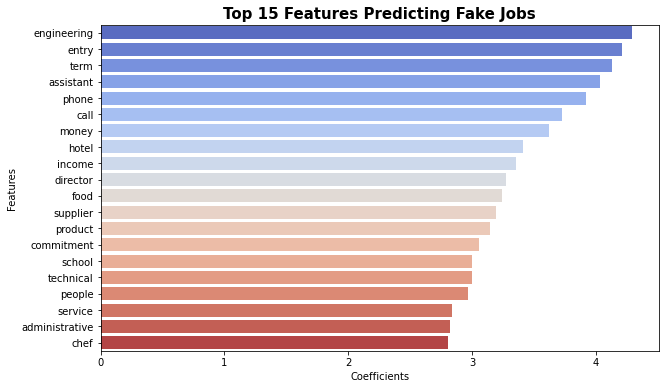

In [109]:
# plot barchart on top 20 features predicting fake jobs (fraudulent = 1)
plt.figure(figsize = (10, 6))
sns.barplot(data = top_pos_coefs, x = 'Coefficients', y = 'Features', palette = 'coolwarm')
plt.title('Top 15 Features Predicting Fake Jobs', fontweight = 'bold', fontsize = 15)
plt.xlabel('Coefficients');

**Observation**: Aligned with our EDA, fake jobs are commonly from the engineering field and involve jobs that are simpler, e.g. data entry (as seen by #2 feature `entry`) and administrative assistant (as seen by #4 feature `assistant` and #19 feature `administrative`).

In [110]:
# top 20 features in predicting real jobs (fraudulent = 0)
top_neg_coefs = lr_coefs.sort_values(by = 'Coefficients').head(20)
top_neg_coefs

,Coefficients,Features
1959,-4.587777,website
606,-3.737264,english
950,-3.306067,interview
636,-3.005897,essential
297,-2.912303,client
1739,-2.802605,state
341,-2.623332,company
244,-2.584456,candidate
815,-2.540519,growing
1221,-2.526806,open


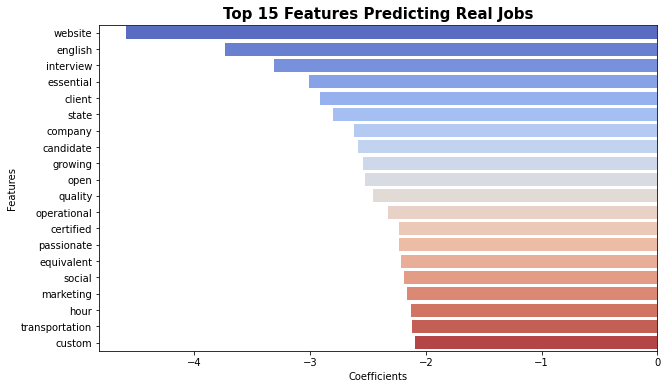

In [111]:
# plot barchart on top 20 features predicting real jobs (fraudulent = 0)
plt.figure(figsize = (10, 6))
sns.barplot(data = top_neg_coefs, x = 'Coefficients', y = 'Features', palette = 'coolwarm')
plt.title('Top 15 Features Predicting Real Jobs', fontweight = 'bold', fontsize = 15)
plt.xlabel('Coefficients');

**Observation**: Real jobs typically have more complex hiring process which includes interviews (as seen by feature #3 `interview`) and require candidates with higher qualifications (as seen by feature #13 `certified`).

In [112]:
# create a new column to store the absolute coefficients
lr_coefs['Absolute Coefficients'] = lr_coefs['Coefficients'].abs()
top_coefs = lr_coefs.sort_values(by = 'Absolute Coefficients', ascending = False).head(20)
top_coefs

,Coefficients,Features,Absolute Coefficients
1959,-4.587777,website,4.587777
605,4.290443,engineering,4.290443
623,4.210568,entry,4.210568
1822,4.128636,term,4.128636
141,4.029955,assistant,4.029955
1314,3.919406,phone,3.919406
606,-3.737264,english,3.737264
240,3.721863,call,3.721863
1148,3.616886,money,3.616886
857,3.411195,hotel,3.411195


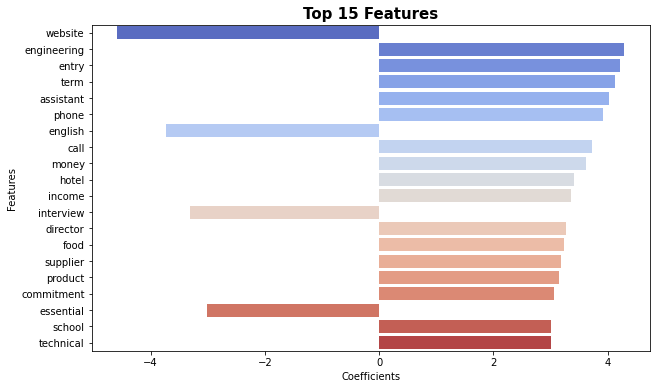

In [113]:
# plot barchart on top 20 features predicting real jobs (fraudulent = 0)
plt.figure(figsize = (10, 6))
sns.barplot(data = top_coefs, x = 'Coefficients', y = 'Features', palette = 'coolwarm')
plt.title('Top 15 Features', fontweight = 'bold', fontsize = 15)
plt.xlabel('Coefficients');

### Confusion Matrix

In [114]:
# predict y using selected model
y_predicted = best_model.predict(X_test)

In [115]:
# extracting values of confusion matrix
cm = confusion_matrix(y_test, y_predicted)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 3259
False Positives: 156
False Negatives: 29
True Positives: 117


In [116]:
# creating labels for the confusion matrix
modified_cm = []
for index, value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

In [117]:
# computing scores to input in confusion matrix
accuracy = accuracy_score(y_test, y_predicted)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)

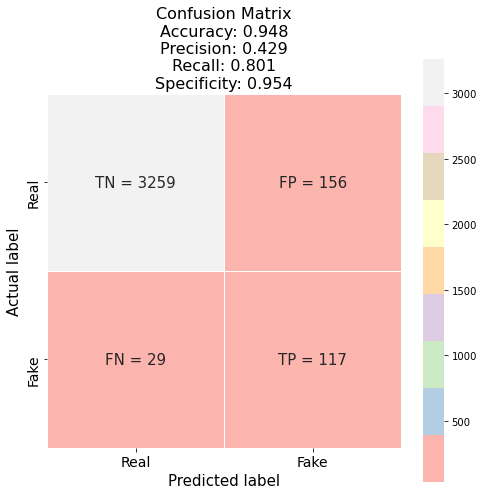

In [118]:
# plot confusion matrix of logreg tvec with labels
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = np.array(modified_cm), fmt = '', annot_kws = {'size': 15}, linewidths = 0.5,
            square = True, cmap = 'Pastel1', xticklabels = ['Real', 'Fake'], yticklabels = ['Real', 'Fake'])

plt.ylabel('Actual label', fontsize = 15)
plt.xlabel('Predicted label', fontsize = 15)
plt.tick_params(labelsize = 14)
plt.title('Confusion Matrix' + '\n'
          + 'Accuracy: {:.3f}'.format(accuracy) + '\n' 
          + 'Precision: {:.3f}'.format(precision) + '\n'
          + 'Recall: {:.3f}'.format(recall) + '\n'
          + 'Specificity: {:.3f}'.format(specificity),
          size = 16);

plt.tight_layout()

**Observation**: The model is able to correctly predict the positive (fake) classes 80% of the time, as seen by the high recall score. This means that of the 146 fake jobs, the model is able to correctly identify 117 (80%) of them, with 29 false negatives. If we deploy the model to filter job ads on job portals, only 29 fraudulent jobs will be uploaded now as compared to 146 before, largely reducing the risk for job-seekers.

Of course, there would also be a trade-off. While the recall score is high, the precision is low at 0.429. This means that of the 273 jobs that the model predicts as fake, only 117 were really fake. The remaining 156 genuine job ads will not be allowed to be published on job portals, and these genuine employers may have a difficult time finding candidates to fill their positions.

<Figure size 720x720 with 0 Axes>

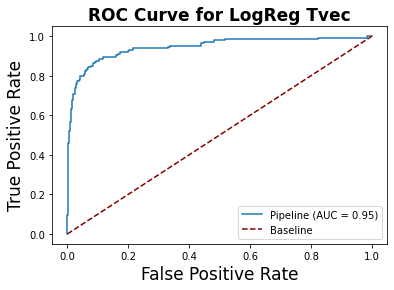

In [119]:
# plot roc curve

plt.figure(figsize=(10,10))
ax = plot_roc_curve(sm_tvec_logreg_best.best_estimator_, X_test,y_test)
plt.plot([0,1],[0,1],label = 'Baseline', linestyle = '--', color = 'maroon')
plt.legend()

# set title, suptitle and x and y labels
plt.title("ROC Curve for LogReg Tvec", weight='bold', fontsize = 17) 
plt.xlabel('False Positive Rate', fontsize = 17)
plt.ylabel('True Positive Rate', fontsize = 17);

### Feature Importance for Random Forest

In [120]:
# feature importance coefficients
coefficients = sm_cvec_rf_best.best_estimator_.named_steps['rf'].feature_importances_
coefficients

array([0.00000000e+00, 2.51066777e-04, 2.79673262e-04, 8.36057760e-04,
       1.00685782e-03, 3.47290294e-04, 0.00000000e+00, 4.47933122e-04,
       2.96606888e-05, 9.10001430e-05, 5.37905783e-05, 4.29698313e-04,
       4.34717188e-04, 7.68255929e-04, 4.00347941e-04, 3.93480163e-04,
       4.98253252e-04, 0.00000000e+00, 3.92715219e-05, 0.00000000e+00,
       1.07804439e-06, 1.89824144e-06, 1.84193866e-04, 9.51502756e-05,
       1.98880642e-04, 0.00000000e+00, 1.95144239e-04, 7.44822695e-04,
       7.23450240e-03, 2.17318163e-04, 1.67405470e-07, 2.41618313e-03,
       1.28224029e-05, 3.68366464e-03, 3.63123140e-04, 2.56423948e-04,
       3.69782213e-03, 6.57828428e-04, 0.00000000e+00, 1.97750716e-06,
       2.29521217e-04, 7.24994511e-05, 3.52091589e-04, 1.99522900e-04,
       2.13275481e-03, 1.28406964e-04, 1.39462040e-04, 2.62861916e-04,
       5.52885682e-04, 2.36961288e-05, 2.26175972e-04, 3.04834655e-04,
       9.36174057e-04, 1.89232802e-03, 4.66676682e-04, 3.03059467e-04,
      

In [121]:
rf_coefs = pd.DataFrame(coefficients)
rf_coefs.head(1)

,0
0,0.0


In [122]:
# get the feature names of the best model
text_col = [w for w in sm_cvec_rf_best.best_estimator_.named_steps['transformer1']. \
            named_transformers_['cvec'].get_feature_names()]
cols = (text_col + [c for c in X.columns if c!= 'text_lemma'])
rf_coefs['Feature Names'] = cols

In [123]:
# rename the column names
rf_coefs.columns = ['Coefficients', 'Feature Names']

In [124]:
# top 15 features in predicting fake jobs (fraudulent = 1)
best_pos = rf_coefs.sort_values(by = 'Coefficients', ascending = False).head(15)
best_pos

,Coefficients,Feature Names
647,0.122292,has_company_logo
648,0.040476,has_questions
103,0.028867,data entry
658,0.026582,required_education_Bachelor's Degree
649,0.023557,word_length
369,0.022522,oil gas
652,0.021897,required_experience_Entry level
661,0.020905,required_education_High School or equivalent
682,0.020763,industry_grp_Oil & Energy
655,0.015581,required_experience_Mid-Senior level


In [125]:
# top 15 features in predicting real jobs (fraudulent = 0)
best_neg = rf_coefs.sort_values(by = 'Coefficients').head(15)
best_neg

,Coefficients,Feature Names
0,0.0,accommodationswillingness availability
482,0.0,running mail
590,0.0,urgent packagesperform
599,0.0,verbal writtenlifting
225,0.0,guidelinesadhere safety
199,0.0,filesprovide backfill
198,0.0,file ship
197,0.0,file purge
251,0.0,inserting delivery
196,0.0,file paper


In [126]:
# predict y using selected model
y_predicted1 = sm_cvec_rf_best.best_estimator_.predict(X_test)

In [127]:
# extracting values of confusion matrix
cm = confusion_matrix(y_test, y_predicted1)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 3405
False Positives: 10
False Negatives: 79
True Positives: 67


### Misclassified Data

In [128]:
# add the predictions into the test df
predicted_df = pd.DataFrame(data = y_predicted, columns = ['y_pred'], index = X_test.index.copy())
test_pred_df = pd.concat([X_test, y_test.to_frame(), predicted_df], axis = 1)
test_pred_df.head(1)

,has_company_logo,has_questions,text_lemma,word_length,required_experience_Associate,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_education_Associate Degree,required_education_Bachelor's Degree,required_education_Certification,required_education_Doctorate,required_education_High School or equivalent,required_education_Master's Degree,required_education_Professional,required_education_Some College Coursework Completed,required_education_Unspecified,required_education_Vocational,industry_grp_Admin/HR,industry_grp_Architecture & Engineering,industry_grp_Arts & Entertainment,industry_grp_Broadcasting/Publishing,industry_grp_Business/Consultancy,industry_grp_Computer Prog,industry_grp_Construction,industry_grp_Education,industry_grp_F&B,industry_grp_Financial Services,industry_grp_Healthcare,industry_grp_ICT,industry_grp_Legal & Accounting,industry_grp_Manufacturing,industry_grp_Marketing/Advertising,industry_grp_Oil & Energy,industry_grp_Others,industry_grp_Public Admin,industry_grp_Real Estate,industry_grp_Scientific R&D,industry_grp_Security and Investigations,industry_grp_Social Services,industry_grp_Telecommunications,industry_grp_Transportation & Storage,industry_grp_Wholesale/Retail,fraudulent,y_pred
1591,1,1,contract qa engineer always open connecting experienced qa engineer interested contract opportun...,154,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [129]:
# filter for false positives (misclassified data)
false_positives = test_pred_df[(test_pred_df['fraudulent'] == 0) & (test_pred_df['y_pred'] == 1)]
false_positives.head()

,has_company_logo,has_questions,text_lemma,word_length,required_experience_Associate,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_education_Associate Degree,required_education_Bachelor's Degree,required_education_Certification,required_education_Doctorate,required_education_High School or equivalent,required_education_Master's Degree,required_education_Professional,required_education_Some College Coursework Completed,required_education_Unspecified,required_education_Vocational,industry_grp_Admin/HR,industry_grp_Architecture & Engineering,industry_grp_Arts & Entertainment,industry_grp_Broadcasting/Publishing,industry_grp_Business/Consultancy,industry_grp_Computer Prog,industry_grp_Construction,industry_grp_Education,industry_grp_F&B,industry_grp_Financial Services,industry_grp_Healthcare,industry_grp_ICT,industry_grp_Legal & Accounting,industry_grp_Manufacturing,industry_grp_Marketing/Advertising,industry_grp_Oil & Energy,industry_grp_Others,industry_grp_Public Admin,industry_grp_Real Estate,industry_grp_Scientific R&D,industry_grp_Security and Investigations,industry_grp_Social Services,industry_grp_Telecommunications,industry_grp_Transportation & Storage,industry_grp_Wholesale/Retail,fraudulent,y_pred
8522,0,0,new development project leader job hereregularly provide feedback idea solution process improvem...,394,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2072,0,0,sqa engineer qualification bachelor degree year software quality engineering responsibility soft...,98,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2655,0,1,mcafee technology security specialist position encompasses sale engineering integration engineer...,72,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
8573,0,0,peoplesoft hcm analyst job responsibility interact user community gather document business requi...,56,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10384,1,1,executive assistant ceo office manager suneris inc medical device focus bringing new technology ...,120,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [130]:
# export fp to csv
false_positives.to_csv('../data/false_positives.csv', index = False)

**Observation**: There were 156 jobs classified incorrectly as fraudulent even though they were genuine because these jobs are related to engineering/design or office admin, which are top features in predicting fake jobs.

In [131]:
# filter for false negatives (misclassified data)
false_negatives = test_pred_df[(test_pred_df['fraudulent'] == 1) & (test_pred_df['y_pred'] == 0)]
false_negatives.head()

,has_company_logo,has_questions,text_lemma,word_length,required_experience_Associate,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_education_Associate Degree,required_education_Bachelor's Degree,required_education_Certification,required_education_Doctorate,required_education_High School or equivalent,required_education_Master's Degree,required_education_Professional,required_education_Some College Coursework Completed,required_education_Unspecified,required_education_Vocational,industry_grp_Admin/HR,industry_grp_Architecture & Engineering,industry_grp_Arts & Entertainment,industry_grp_Broadcasting/Publishing,industry_grp_Business/Consultancy,industry_grp_Computer Prog,industry_grp_Construction,industry_grp_Education,industry_grp_F&B,industry_grp_Financial Services,industry_grp_Healthcare,industry_grp_ICT,industry_grp_Legal & Accounting,industry_grp_Manufacturing,industry_grp_Marketing/Advertising,industry_grp_Oil & Energy,industry_grp_Others,industry_grp_Public Admin,industry_grp_Real Estate,industry_grp_Scientific R&D,industry_grp_Security and Investigations,industry_grp_Social Services,industry_grp_Telecommunications,industry_grp_Transportation & Storage,industry_grp_Wholesale/Retail,fraudulent,y_pred
11719,0,0,part job home daily pay part job home daily pay minimum hour day anytime required job earn every...,27,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4433,1,1,market operation manager exemptshift workedmonday sunday day nightssalary starting salary rampin...,317,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11824,0,1,vacancy nanny cook driver housekeeper needed hiring home domestic mother home mom died told many...,156,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1600,1,0,representative seeking candidate whose core value integrity compassion responsibility focused bu...,39,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4343,1,1,call center representative responsible collection delinquent accountsperform inquiry data entry ...,107,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [132]:
# export fn to csv
false_negatives.to_csv('../data/false_negatives.csv', index = False)

**Observation**: There were 29 jobs classified incorrectly as genuine even though they were fraudulent because these jobs required candidates to have specialised skills and more advanced qualifications such as java, software development and UX design.